# NSC 325 Sweet Spot Identification
Elijah Flores, Aditya Holla, Jayant Bhaskaruni, Beshoy Shaker, and Ameera Aslam

The University of Texas at Austin

In [505]:
# Import statements
%pip install pykrige
%pip install xgboost
import os
import random
from skimage.feature import peak_local_max
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split, KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap
from pykrige.ok import OrdinaryKriging
from sklearn.preprocessing import MinMaxScaler

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [506]:
# Random Seed for reproducibility
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [507]:
# Convert facies dummy variables to single categorical column BEFORE scaling
def get_facies_label(row):
    if row.get('facies_2', 0) == 1:
        return 2
    elif row.get('facies_3', 0) == 1:
        return 3
    elif row.get('facies_4', 0) == 1:
        return 4
    elif row.get('facies_5', 0) == 1:
        return 5
    else:
        return 1

In [508]:
# Interpolate other features to grid using kriging
def krige_to_grid(df_in, feature, grid_x, grid_y):
    x = df_in['bh_x'].values
    y = df_in['bh_y'].values
    z = df_in[feature].values

    mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
    x, y, z = x[mask], y[mask], z[mask]

    OK = OrdinaryKriging(
        x, y, z,
        variogram_model='spherical',
        verbose=False,
        enable_plotting=False
    )
    z_pred, _ = OK.execute('grid', grid_x, grid_y)  # (len(grid_y), len(grid_x))
    return z_pred

In [509]:
# Create kriging plots
def create_kriging_plot(
    df, x_col, y_col, z_col, title='', 
    cmap='YlOrRd', add_contours=False, contour_col=None):    
    # Extract x, y, z for main map
    x = df[x_col].values
    y = df[y_col].values
    z = df[z_col].values
    mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
    x, y, z = x[mask], y[mask], z[mask]

    # Build grid
    grid_x = np.linspace(x.min(), x.max(), 150)
    grid_y = np.linspace(y.min(), y.max(), 150)
    grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

    # Krige main variable
    OK = OrdinaryKriging(
        x, y, z,
        variogram_model='spherical',
        verbose=False,
        enable_plotting=False
    )
    z_grid, _ = OK.execute('grid', grid_x, grid_y)   # shape (ny, nx)

    # Plot heatmap of kriged z
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(
        z_grid,
        extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
        origin='lower',
        cmap=cmap,
        aspect='auto',
        alpha=0.8
    )
    plt.colorbar(im, ax=ax, label=z_col.replace('_', ' ').title())

    # Color wells by kriged grid value at their position
    x_idx = np.searchsorted(grid_x, df[x_col])
    y_idx = np.searchsorted(grid_y, df[y_col])
    x_idx = np.clip(x_idx, 0, len(grid_x) - 1)
    y_idx = np.clip(y_idx, 0, len(grid_y) - 1)

    well_scores = z_grid[y_idx, x_idx]   # note: [row (y), col (x)]

    ax.scatter(
        df[x_col], df[y_col],
        c=well_scores,
        cmap=cmap,
        s=50,
        edgecolor='black',
        linewidth=1,
        alpha=0.8,
        label='Wells'
    )

    # kriged contours of another variable
    if add_contours and contour_col is not None:
        cx = df[x_col].values
        cy = df[y_col].values
        cz = df[contour_col].values
        mask_c = ~(np.isnan(cx) | np.isnan(cy) | np.isnan(cz))
        cx, cy, cz = cx[mask_c], cy[mask_c], cz[mask_c]

        OK_c = OrdinaryKriging(
            cx, cy, cz,
            variogram_model='spherical',
            verbose=False,
            enable_plotting=False
        )
        c_grid, _ = OK_c.execute('grid', grid_x, grid_y)

        contours = ax.contour(
            grid_x, grid_y, c_grid,
            colors='black', linewidths=1.5, levels=8, alpha=0.7
        )
        ax.clabel(contours, inline=True, fontsize=10, fmt='%0.1f')

    # Formatting
    ax.set_xlabel('X Coordinate', fontsize=18)
    ax.set_ylabel('Y Coordinate', fontsize=18)
    ax.set_title(title if title else f'{z_col.replace("_", " ").title()} Map', fontsize=22)
    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
    plt.tight_layout()
    return fig, ax, grid_x, grid_y, z_grid


In [510]:
# Read in file
filename = 'sweetspot_UT_Austin.csv'
df = pd.read_csv(filename)

In [511]:
# Print out the amount of missing values
df[(df == 0).any(axis=1)]

,Well Number,Well Name,Bottomhole X,Bottomhole Y,Co [MSTB],Cw (bbl),POROS,KX,KY,TD(MD),Cg (mmcf),FACIES,P_2020-1-6,P_2029-1-1
7,8,PO1_8,12877.11,11141.88,0.0,1.24460,0.074247,0.000270,0.000270,8638.6,0.0,5,3520.804323,2949.434450
8,9,PO1_9,14034.61,11141.88,0.0,1.30679,0.073380,0.000284,0.000284,8684.3,0.0,5,3535.967335,2954.485548
26,27,PO1_27,14034.61,8537.52,0.0,30.15660,0.116111,0.033130,0.010039,8645.4,0.0,4,3523.060526,2676.168143
27,28,PO1_28,14034.61,5933.16,0.0,37.77570,0.112872,0.012573,0.012573,8647.7,0.0,4,3523.823653,2694.598799
46,47,PO1_47,14034.61,3328.80,0.0,87.57740,0.143755,0.038000,0.038000,8691.2,0.0,3,3538.256717,2515.127738


In [512]:
# Well number and name are redundant (can use row index) and can be removed.
df.drop(columns=['Well Number', 'Well Name'], inplace=True)

In [513]:
# Rename column headers to be more human-readable
mappings = {
    'Bottomhole X': 'bh_x',         # Bottomhole X-coordinate
    'Bottomhole Y': 'bh_y',         # Bottomhole Y-coordinate
    'Co [MSTB]': 'oil_prod_mstb',   # Cumulative oil production, thousand stock tank barrels
    'Cw (bbl)': 'water_prod_bbl',   # Cumulative water production, barrels
    'POROS': 'porosity',            # Porosity
    'KX': 'perm_x',                 # X permeability
    'KY': 'perm_y',                 # Y permeability
    'TD(MD)': 'total_depth_md',     # Total depth (measured depth)
    'Cg (mmcf)': 'gas_prod_mmcf',   # Gas production, million cubic feet
    'FACIES': 'facies',             # Facies
    'P_2020-1-6': 'past_pressure',  # Pressure on January 6, 2020
    'P_2029-1-1': 'future_pressure' # Predicted pressure on January 1, 2029
}
df.rename(columns=mappings, inplace=True)

C:\Users\shake\AppData\Local\Temp\ipykernel_120500\3457237863.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df_temp, labels=df_temp.columns)


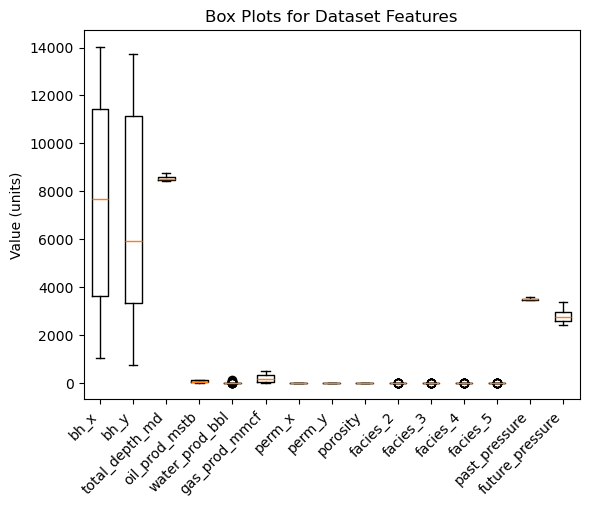

In [514]:
# One-hot encode facies for correlation analysis
facies_dummies = pd.get_dummies(df['facies'], prefix='facies', drop_first=False)

df_temp = pd.get_dummies(df, columns=['facies'], drop_first=True)
df_temp = df_temp[['bh_x', 'bh_y', 'total_depth_md', 'oil_prod_mstb', 'water_prod_bbl', 'gas_prod_mmcf', 'perm_x', 'perm_y', 'porosity', 'facies_2', 'facies_3', 'facies_4', 'facies_5', 'past_pressure', 'future_pressure']]

# Boxplots to check for outliers
plt.boxplot(df_temp, labels=df_temp.columns)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Value (units)')
plt.title('Box Plots for Dataset Features')
plt.show()

In [515]:
# Add harmonic mean permeability to dataframe
df['perm_hm'] = 2 * df['perm_x'] * df['perm_y'] / (df['perm_x'] + df['perm_y'])

# Replace inf and drop NaNs in scaled columns
columns_to_scale = ['total_depth_md']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_scale)

# Create scaled copy
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Keep facies as original integer labels
df_scaled['facies'] = df['facies'].astype(int)

# Build grid and krige depth
grid_x = np.linspace(df_scaled['bh_x'].min(), df_scaled['bh_x'].max(), 150)
grid_y = np.linspace(df_scaled['bh_y'].min(), df_scaled['bh_y'].max(), 150)
depth_grid = krige_to_grid(df_scaled, 'total_depth_md', grid_x, grid_y)
numeric_df = df.select_dtypes(include=[np.number])

# Dataframe including numeric features and facies dummies
df_corr = pd.concat([numeric_df, facies_dummies], axis=1)

# Create facies column in original df before scaling
df['facies'] = df.apply(get_facies_label, axis=1)

# Scale relevant columns
columns_to_scale = ['perm_hm', 'porosity', 'oil_prod_mstb', 'gas_prod_mmcf', 
                    'total_depth_md', 'water_prod_bbl']

# Replace inf values and drop rows with NaN in columns to scale
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_scale)

# Create scaled dataframe
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Keep facies column in df_scaled (already created above)
df_scaled['facies'] = df['facies']

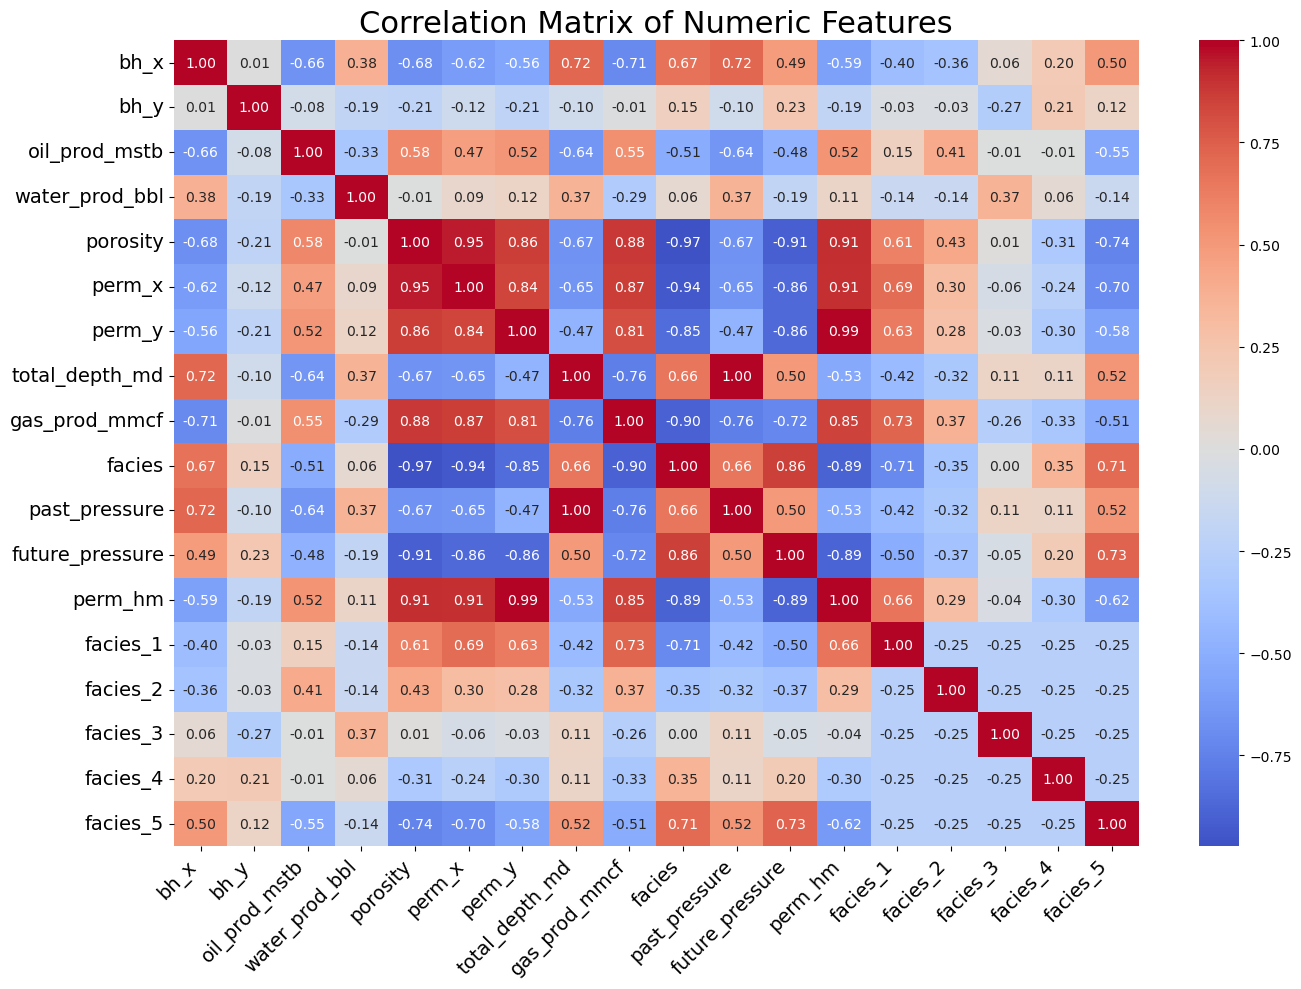

In [516]:
# Full correlation matrix including dummy facies
correlation_matrix = df_corr.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,        
    fmt=".2f",
    cmap='coolwarm',
    center=0
)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.title('Correlation Matrix of Numeric Features', fontsize=22)
plt.tight_layout()
plt.show()

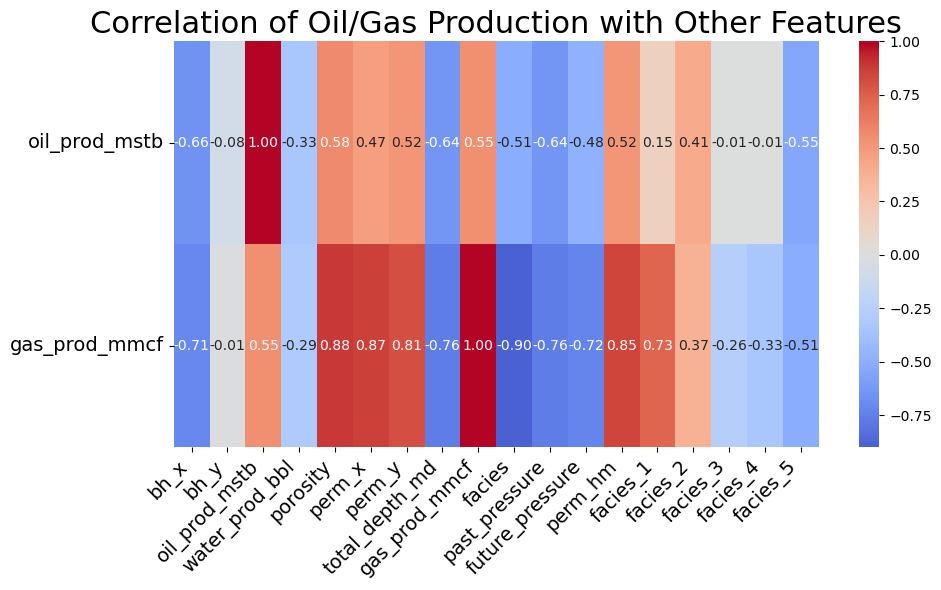

In [517]:
# Correlation of oil and gas production with other features
rows_of_interest = ['oil_prod_mstb', 'gas_prod_mmcf']

plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix.loc[rows_of_interest, :],
    annot=True, fmt=".2f", cmap='coolwarm', center=0
)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.title('Correlation of Oil/Gas Production with Other Features', fontsize=22)
plt.tight_layout()
plt.show()

In [518]:
# Missing value imputation

# Replace 0s with NaN 
df_scaled['oil_prod_mstb'] = df_scaled['oil_prod_mstb'].replace(0, np.nan)
df_scaled['gas_prod_mmcf'] = df_scaled['gas_prod_mmcf'].replace(0, np.nan)

# Median imputation (safer than mean due to outliers)
df_scaled['oil_prod_mstb'] = df_scaled['oil_prod_mstb'].fillna(df['oil_prod_mstb'].median())
df_scaled['gas_prod_mmcf'] = df_scaled['gas_prod_mmcf'].fillna(df['gas_prod_mmcf'].median())

C:\Users\shake\AppData\Local\Temp\ipykernel_120500\700364222.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])


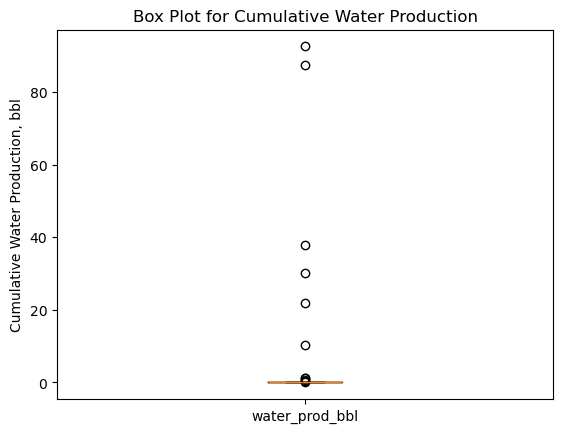

In [519]:
# Water production box plot
plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])
plt.title('Box Plot for Cumulative Water Production')
plt.ylabel('Cumulative Water Production, bbl')
plt.show()

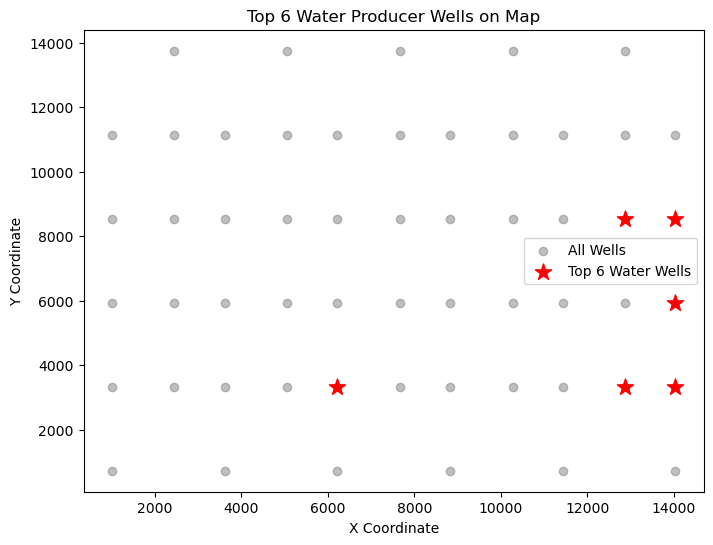

In [520]:
# Select the TOP 6 wells by water_prod_bbl
df_top6 = df.nlargest(6, 'water_prod_bbl')

# Plot top 6
plt.figure(figsize=(8, 6))
plt.scatter(df['bh_x'], df['bh_y'], c='gray', alpha=0.5, label='All Wells')
plt.scatter(df_top6['bh_x'], df_top6['bh_y'], c='r', marker='*', s=150, label='Top 6 Water Wells')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Top 6 Water Producer Wells on Map')
plt.legend()
plt.show()

In [521]:
perm = 2 * df['perm_x'].astype(float) * df['perm_y'].astype(float) / (df['perm_x'].astype(float) + df['perm_y'].astype(float))
print(perm)

0     0.020377
1     0.015088
2     0.022396
3     0.000091
4     0.000067
5     0.000168
6     0.000162
7     0.000270
8     0.000284
9     0.015151
10    0.038947
11    0.050873
12    0.056463
13    0.052861
14    0.037831
15    0.034999
16    0.027062
17    0.019848
18    0.024499
19    0.013012
20    0.021804
21    0.012884
22    0.012158
23    0.004877
24    0.008402
25    0.009065
26    0.015409
27    0.012573
28    0.022922
29    0.053718
30    0.058151
31    0.047167
32    0.050863
33    0.036493
34    0.030338
35    0.038392
36    0.013927
37    0.004137
38    0.009499
39    0.003991
40    0.002784
41    0.004627
42    0.017898
43    0.026014
44    0.038956
45    0.038350
46    0.038000
47    0.041674
48    0.042639
49    0.055685
50    0.044984
51    0.034241
52    0.016377
53    0.012992
54    0.004627
dtype: float64


In [522]:
# Add harmonic mean permeability to dataframe
perm = 2 * df['perm_x'].astype(float) * df['perm_y'].astype(float) / (df['perm_x'].astype(float) + df['perm_y'].astype(float))
df['perm_hm'] = perm
df.head()

,bh_x,bh_y,oil_prod_mstb,water_prod_bbl,porosity,perm_x,perm_y,total_depth_md,gas_prod_mmcf,facies,past_pressure,future_pressure,perm_hm
0,5064.04,13746.23,55.191600,1.617450e-04,0.128029,0.020377,0.020377,8551.7,157.119447,1,3491.971374,2992.403113,0.020377
1,7668.40,13746.23,27.529400,1.394790e-04,0.101876,0.015088,0.015088,8579.9,69.831076,1,3501.327981,2947.374808,0.015088
2,2459.67,13746.23,48.354000,1.973990e-04,0.119220,0.022396,0.022396,8557.1,134.781940,1,3493.763065,2904.053641,0.022396
3,10272.76,13746.23,0.572057,1.440000e-07,0.064132,0.000091,0.000091,8635.5,1.101210,1,3519.775759,3301.826052,0.000091
4,12877.11,13746.23,0.430394,8.560000e-08,0.063078,0.000067,0.000067,8718.6,0.435085,1,3547.347889,3365.597401,0.000067


In [523]:
columns_to_scale = ['perm_hm', 'porosity', 'oil_prod_mstb', 'gas_prod_mmcf', 'total_depth_md', 'water_prod_bbl']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_scale)
# Scale the relevant columns between 0 and 1
scale = MinMaxScaler()
df_scaled = df.copy()
df_scaled[columns_to_scale] = scale.fit_transform(df[columns_to_scale])

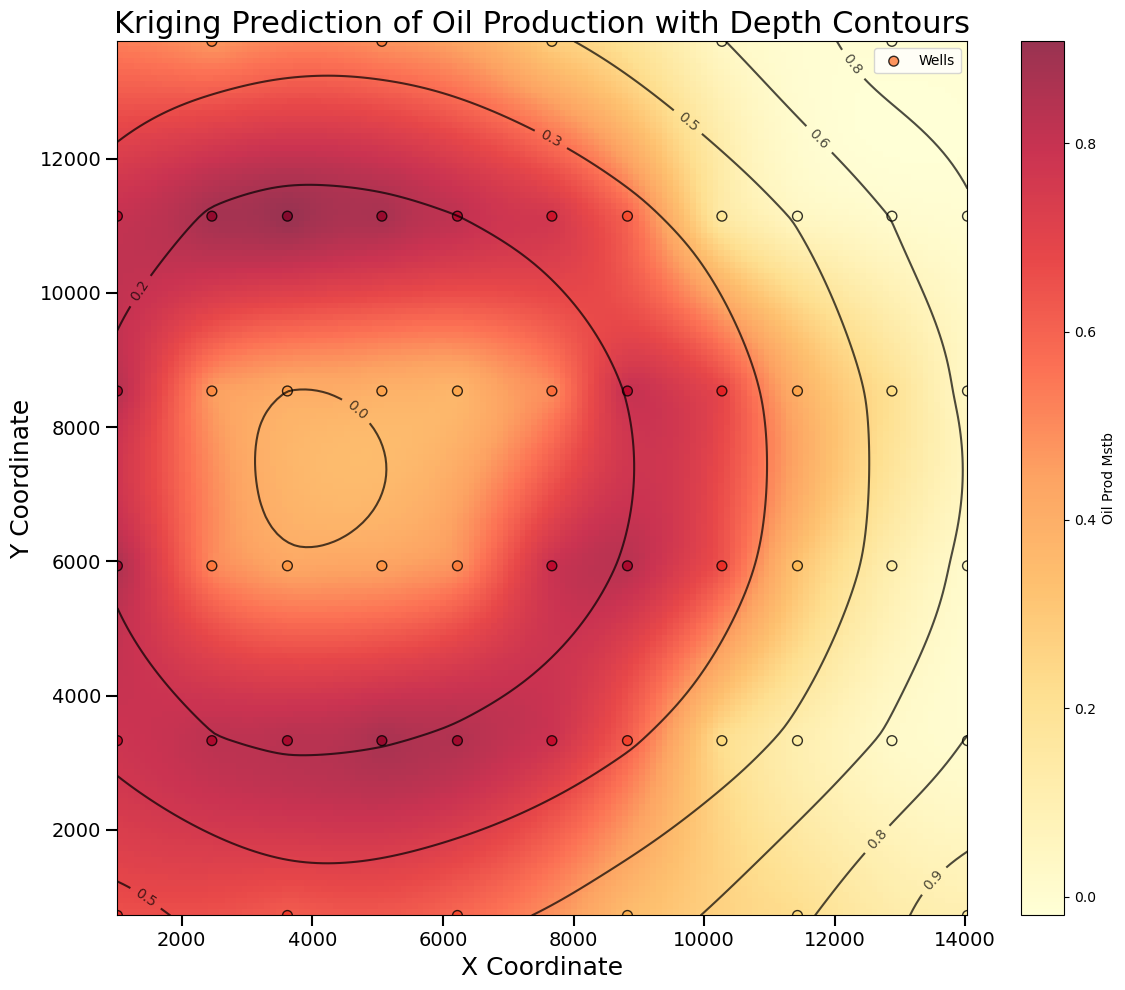

In [524]:
# Kriging plot of oil production with depth contours
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'oil_prod_mstb', 'Kriging Prediction of Oil Production with Depth Contours', cmap='YlOrRd', 
                        add_contours=True, contour_col='total_depth_md')
plt.show()

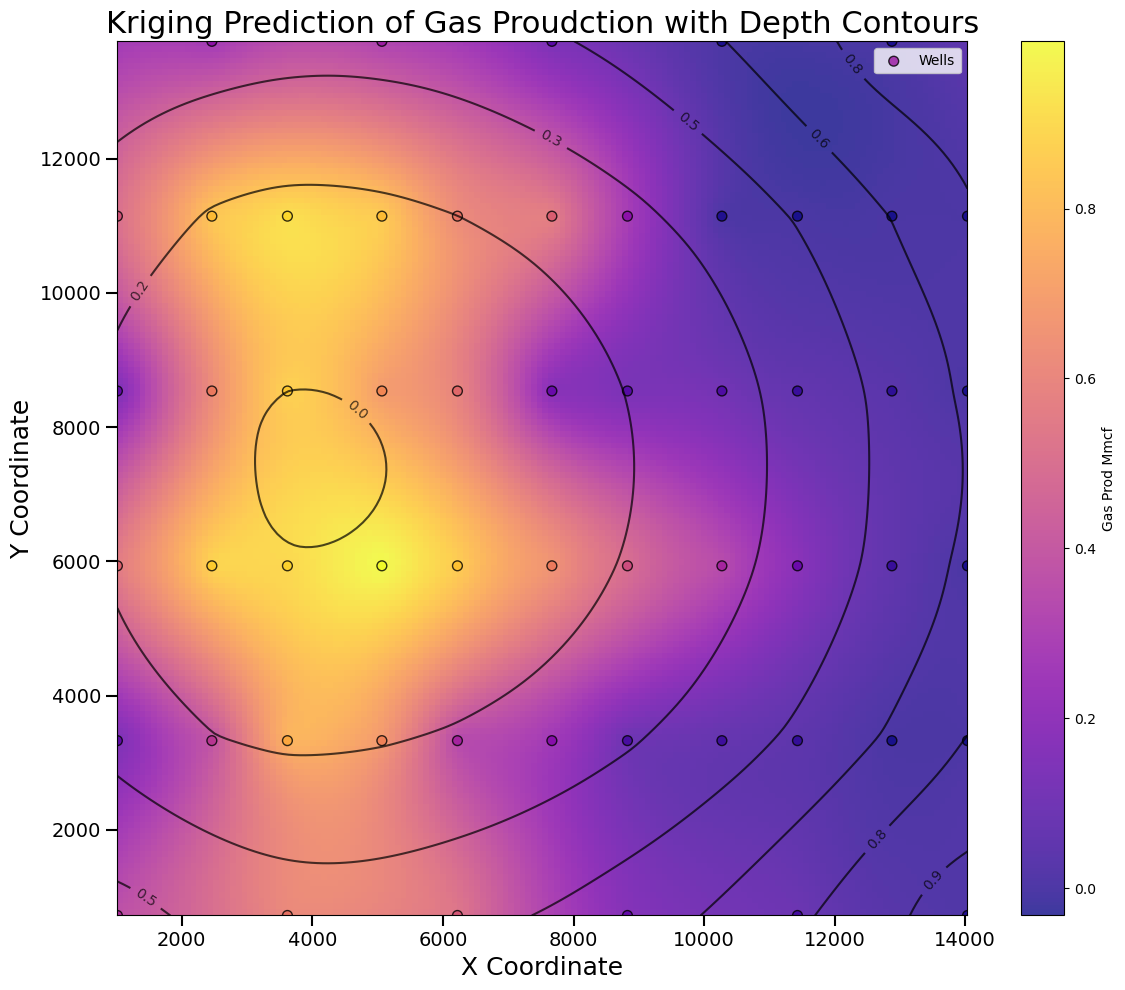

In [525]:
# Kriging interpolation and contour plotting (Gas Production)
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'gas_prod_mmcf', 'Kriging Prediction of Gas Proudction with Depth Contours', cmap='plasma', 
                        add_contours=True, contour_col='total_depth_md')
plt.show()

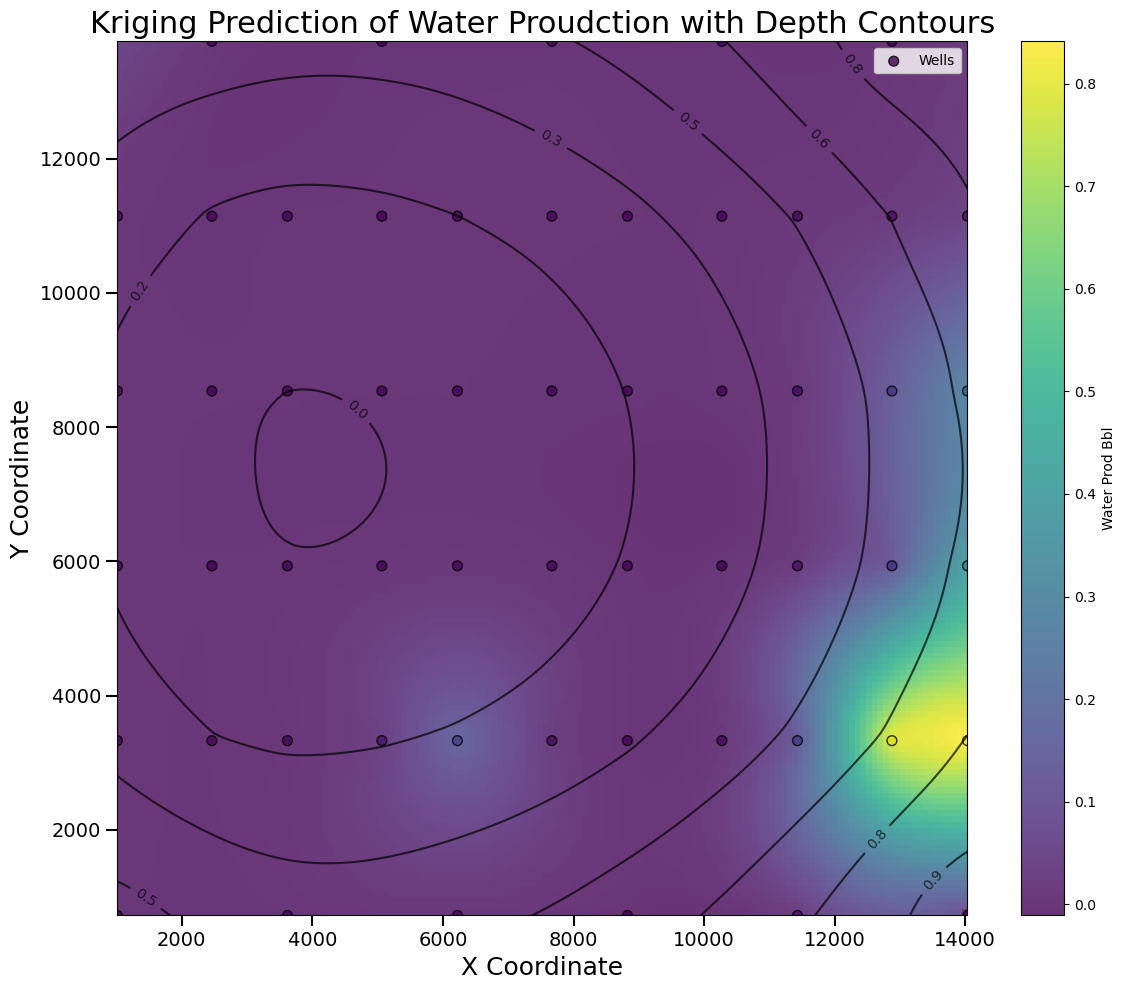

In [526]:
# Kriging interpolation and contour plotting (Water Production)
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'water_prod_bbl', 'Kriging Prediction of Water Proudction with Depth Contours', cmap='viridis', 
                        add_contours=True, contour_col='total_depth_md')
plt.show()

In [527]:
# # Define top-performing wells (top quartile)
# top_oil_threshold = df_scaled['oil_prod_mstb'].quantile(0.75)
# top_gas_threshold = df_scaled['gas_prod_mmcf'].quantile(0.75)

# df_scaled['top_oil_well'] = df_scaled['oil_prod_mstb'] >= top_oil_threshold
# df_scaled['top_gas_well'] = df_scaled['gas_prod_mmcf'] >= top_gas_threshold

# # Check if facies dummy columns exist
facies_cols = ['facies_2', 'facies_3', 'facies_4', 'facies_5']

# if all(col in df_scaled.columns for col in facies_cols):
#     # If dummy columns exist, use them
#     print('Facies sums in top oil wells:')
#     print(df_scaled.loc[df_scaled['top_oil_well'], facies_cols].sum())
#     print('\nFacies sums in top gas wells:')
#     print(df_scaled.loc[df_scaled['top_gas_well'], facies_cols].sum())
# else:
#     # If dummy columns don't exist, use the 'facies' column instead
#     print('Facies distribution in top oil wells:')
#     print(df_scaled.loc[df_scaled['top_oil_well'], 'facies'].value_counts().sort_index())
#     print('\nFacies distribution in top gas wells:')
#     print(df_scaled.loc[df_scaled['top_gas_well'], 'facies'].value_counts().sort_index())
    
#     # Also show as percentages
#     print('\nFacies percentages in top oil wells:')
#     print(df_scaled.loc[df_scaled['top_oil_well'], 'facies'].value_counts(normalize=True).sort_index() * 100)
#     print('\nFacies percentages in top gas wells:')
#     print(df_scaled.loc[df_scaled['top_gas_well'], 'facies'].value_counts(normalize=True).sort_index() * 100)

In [528]:
# Porosity & permeability stats in top wells
# print('\nPorosity in top oil wells:')
# print(df[df_scaled['top_oil_well']]['porosity'].describe())
# print('\nPermeability in top oil wells:')
# print(df[df_scaled['top_oil_well']]['perm_hm'].describe())

In [529]:
# Reload raw data
df = pd.read_csv('sweetspot_UT_Austin.csv')

# Drop redundant identifiers
df.drop(columns=['Well Number', 'Well Name'], inplace=True)

# Rename columns (this brings FACIES -> facies)
mappings = {
    'Bottomhole X': 'bh_x',
    'Bottomhole Y': 'bh_y',
    'Co [MSTB]': 'oil_prod_mstb',
    'Cw (bbl)': 'water_prod_bbl',
    'POROS': 'porosity',
    'KX': 'perm_x',
    'KY': 'perm_y',
    'TD(MD)': 'total_depth_md',
    'Cg (mmcf)': 'gas_prod_mmcf',
    'FACIES': 'facies',
    'P_2020-1-6': 'past_pressure',
    'P_2029-1-1': 'future_pressure'
}
df.rename(columns=mappings, inplace=True)
# Derived permeability
df['perm_hm'] = 2 * df['perm_x'] * df['perm_y'] / (df['perm_x'] + df['perm_y'])

columns_to_scale = [
    'perm_hm', 'porosity', 'oil_prod_mstb', 'gas_prod_mmcf',
    'total_depth_md', 'water_prod_bbl'
]

# Clean and scale
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_scale)

df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# facies stays as integer labels
df_scaled['facies'] = df['facies'].astype(int)

print(df_scaled.columns)         # should include 'facies'
print(df_scaled['facies'].unique())
top_oil = df_scaled.nlargest(10, 'oil_prod_mstb')
print("Facies counts among top 10 oil producers:")
print(top_oil['facies'].value_counts())
facies_dummies = pd.get_dummies(df_scaled['facies'], prefix='facies', drop_first=False)
df_scaled = pd.concat([df_scaled, facies_dummies], axis=1)
# Check facies is present
print(df['facies'].unique())
# One-hot encode facies since it is categorical
df = pd.get_dummies(df_scaled, columns=['facies'], drop_first=True)
top_oil = df.nlargest(10, 'oil_prod_mstb')
print(top_oil[['facies_2','facies_3','facies_4','facies_5']].sum())

Index(['bh_x', 'bh_y', 'oil_prod_mstb', 'water_prod_bbl', 'porosity', 'perm_x',
       'perm_y', 'total_depth_md', 'gas_prod_mmcf', 'facies', 'past_pressure',
       'future_pressure', 'perm_hm'],
      dtype='object')
[3 4 5 2 1]
Facies counts among top 10 oil producers:
facies
2    4
1    3
3    2
4    1
Name: count, dtype: int64
[3 4 5 2 1]
facies_2    4
facies_2    4
facies_3    2
facies_3    2
facies_4    1
facies_4    1
facies_5    0
facies_5    0
dtype: int64


In [530]:
# Display top 5 wells by oil production
top_wells = df_scaled.nlargest(5, 'oil_prod_mstb')[['bh_x', 'bh_y', 'oil_prod_mstb', 'gas_prod_mmcf',
                                             'perm_hm', 'porosity', 'total_depth_md', 'past_pressure'] + facies_cols]
print(top_wells)

       bh_x      bh_y  oil_prod_mstb  gas_prod_mmcf   perm_hm  porosity  \
12  3617.17  11141.88       1.000000       0.919680  0.970942  0.984023   
35  1012.81   5933.16       0.963526       0.569751  0.659820  0.878828   
22  8825.89   8537.52       0.948946       0.129526  0.208175  0.431142   
11  5064.04  11141.88       0.943359       0.857965  0.874694  0.952730   
13  2459.67  11141.88       0.942920       0.843898  0.908931  0.961838   

    total_depth_md  past_pressure  facies_2  facies_3  facies_4  facies_5  
12        0.111945    3464.166989     False     False     False     False  
35        0.131852    3466.456371      True     False     False     False  
22        0.153780    3468.978010     False     False      True     False  
11        0.122908    3465.427808     False     False     False     False  
13        0.138488    3467.219499     False     False     False     False  


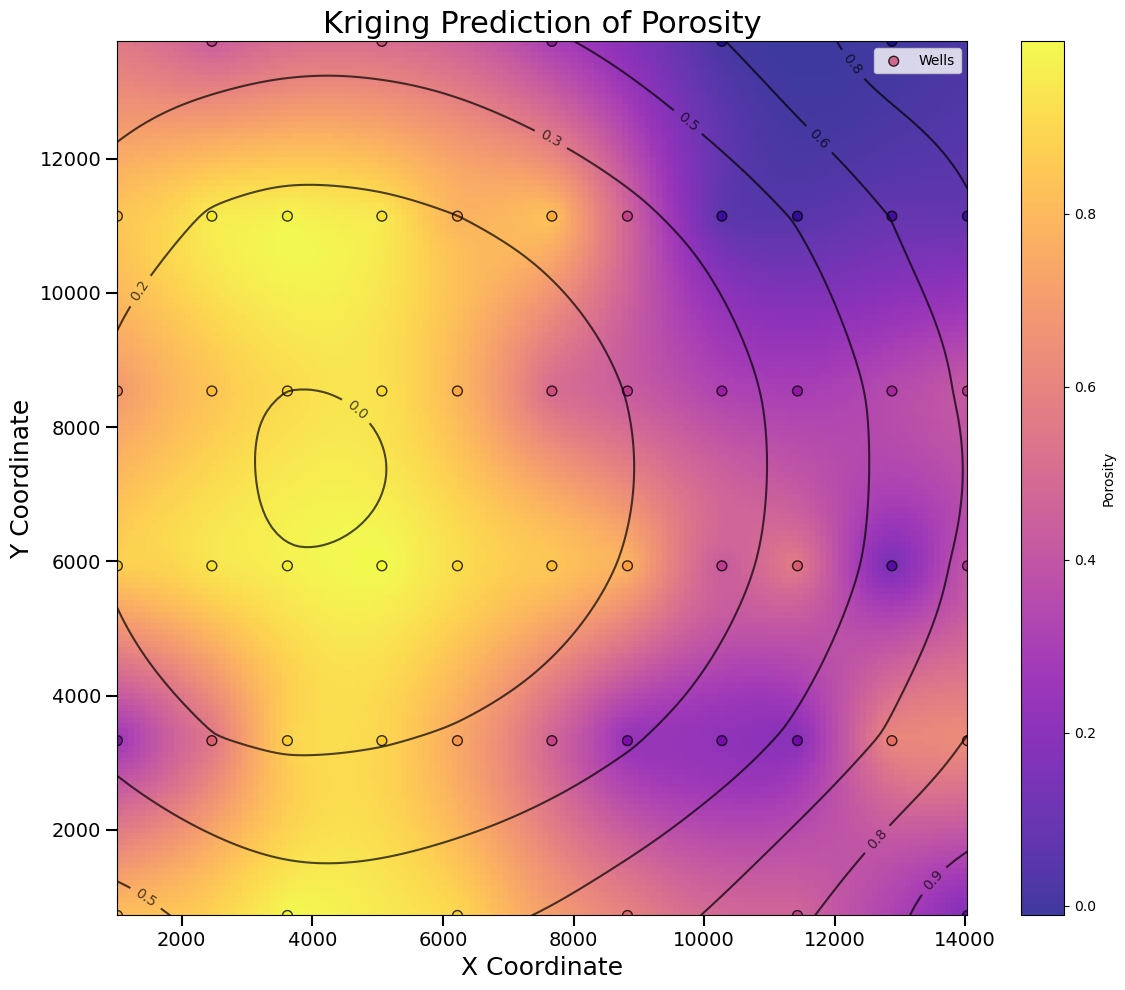

In [531]:
# Kriging plot for porosity
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'porosity', 
                    'Kriging Prediction of Porosity',
                    cmap='plasma', add_contours=True, contour_col='total_depth_md')
plt.show()

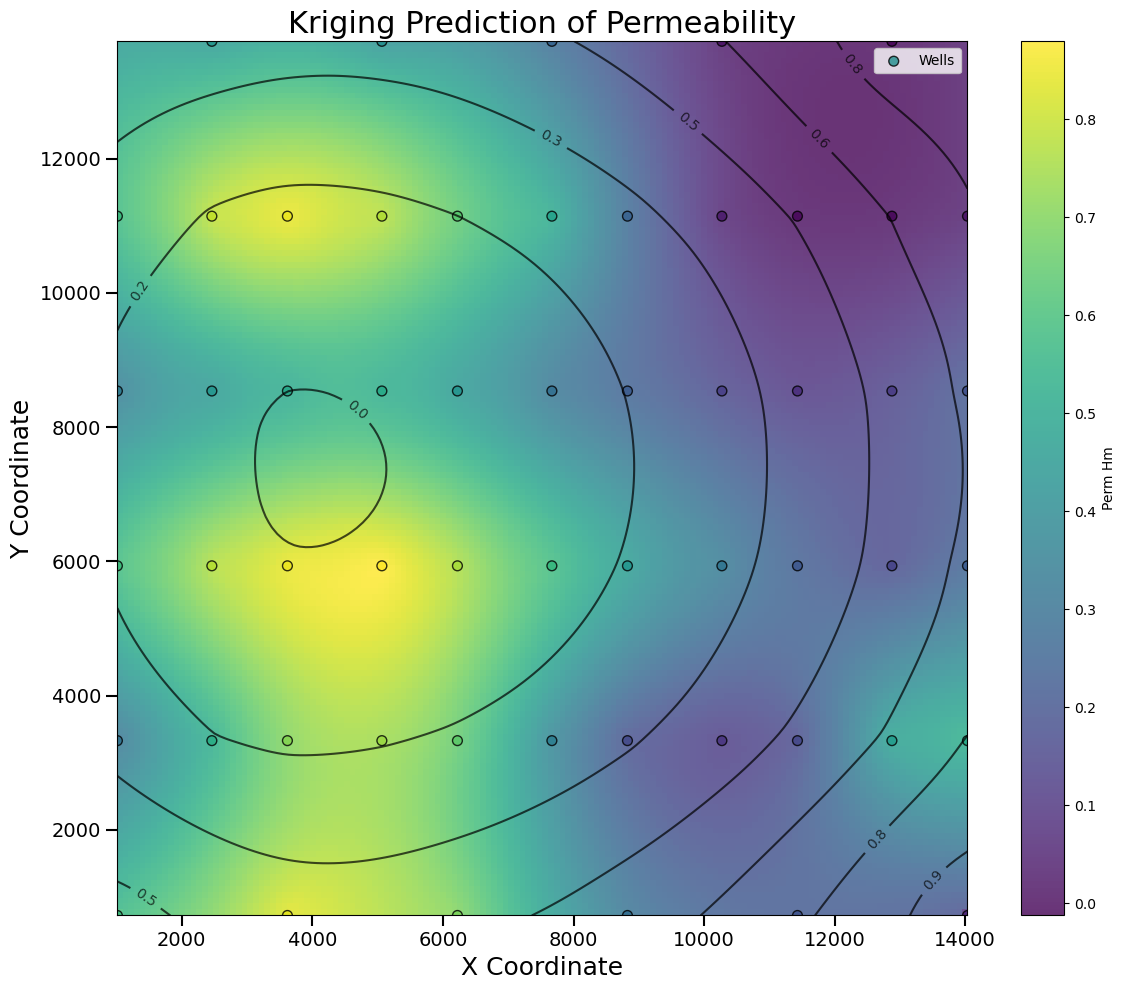

In [532]:
# Kriging plot for permeability
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'perm_hm', 
                    'Kriging Prediction of Permeability',
                    cmap='viridis', add_contours=True, contour_col='total_depth_md')
plt.show()

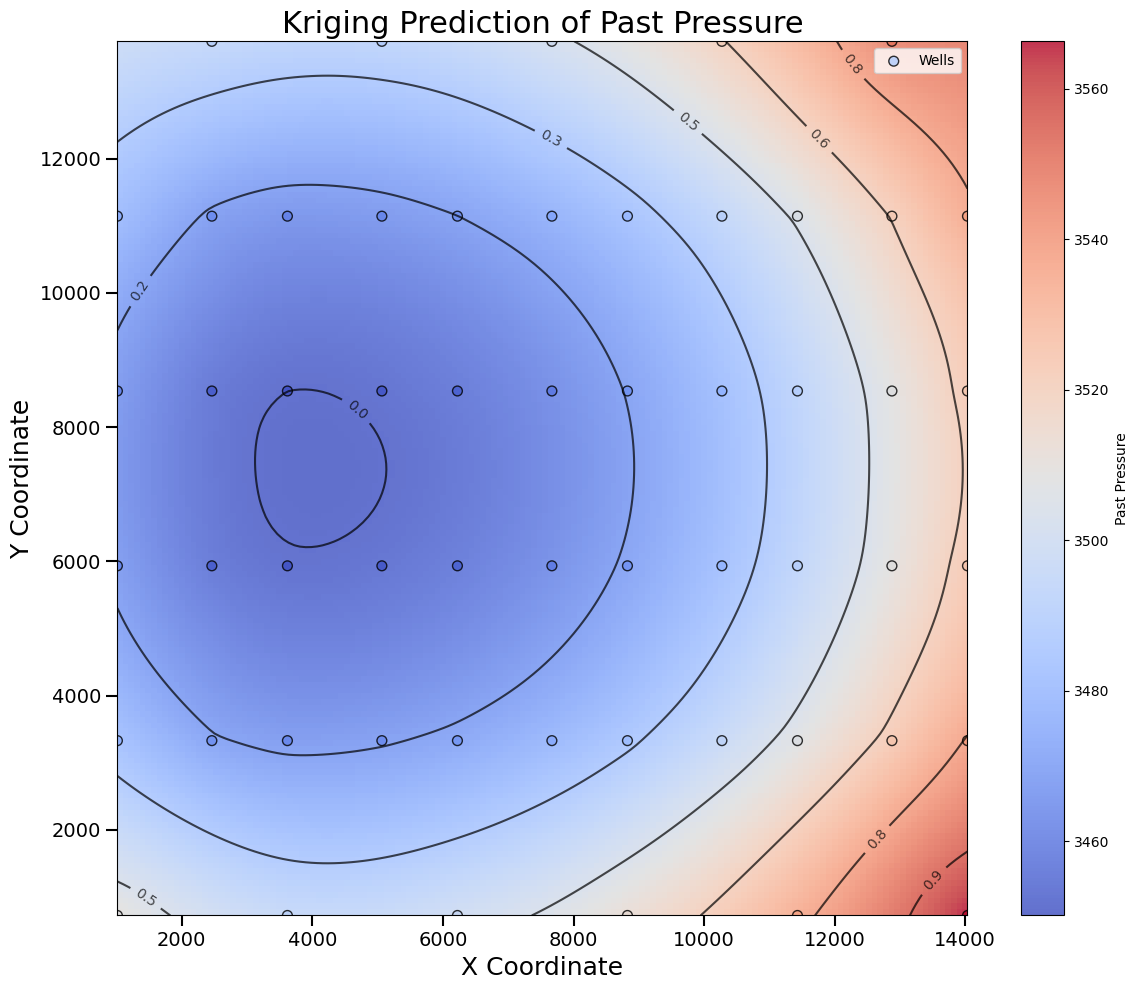

In [533]:
# Kriging plot for past pressure
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'past_pressure', 
                    'Kriging Prediction of Past Pressure',
                    cmap='coolwarm', add_contours=True, contour_col='total_depth_md')
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_120500\4100653678.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


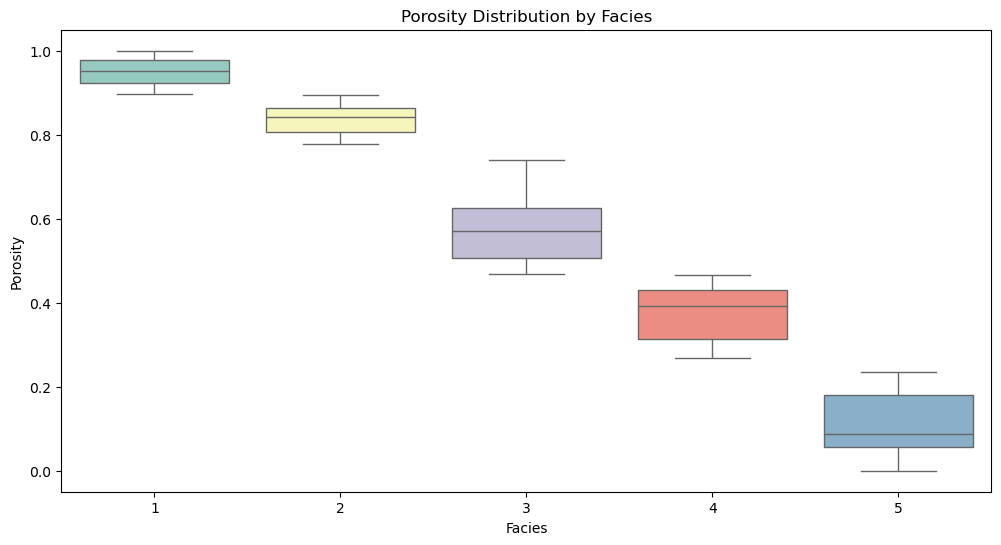

In [534]:
# Convert facies to string for plotting, but keep numeric sorting
df_scaled['facies'] = df_scaled['facies'].astype(int)

plt.figure(figsize=(12,6))
sns.boxplot(
    x='facies', 
    y='porosity', 
    data=df_scaled, 
    palette='Set3', 
    order=sorted(df_scaled['facies'].unique())  # Ensures facies are sorted
)
plt.title('Porosity Distribution by Facies')
plt.xlabel('Facies')
plt.ylabel('Porosity')
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_120500\612320512.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


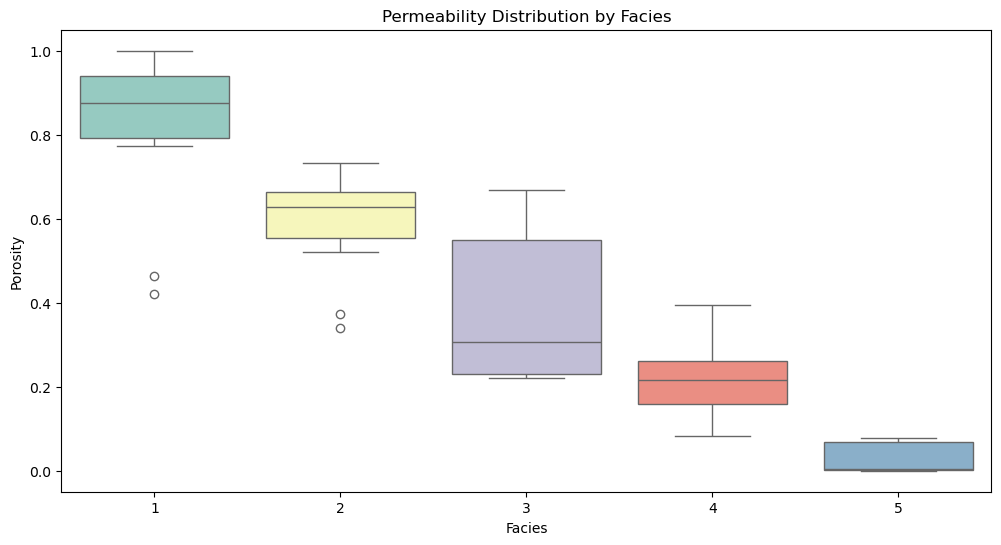

In [535]:
df_scaled['facies'] = df_scaled['facies'].astype(int)

plt.figure(figsize=(12,6))
sns.boxplot(
    x='facies', 
    y='perm_hm', 
    data=df_scaled, 
    palette='Set3', 
    order=sorted(df_scaled['facies'].unique())  # Ensures facies are sorted
)
plt.title('Permeability Distribution by Facies')
plt.xlabel('Facies')
plt.ylabel('Porosity')
plt.show()

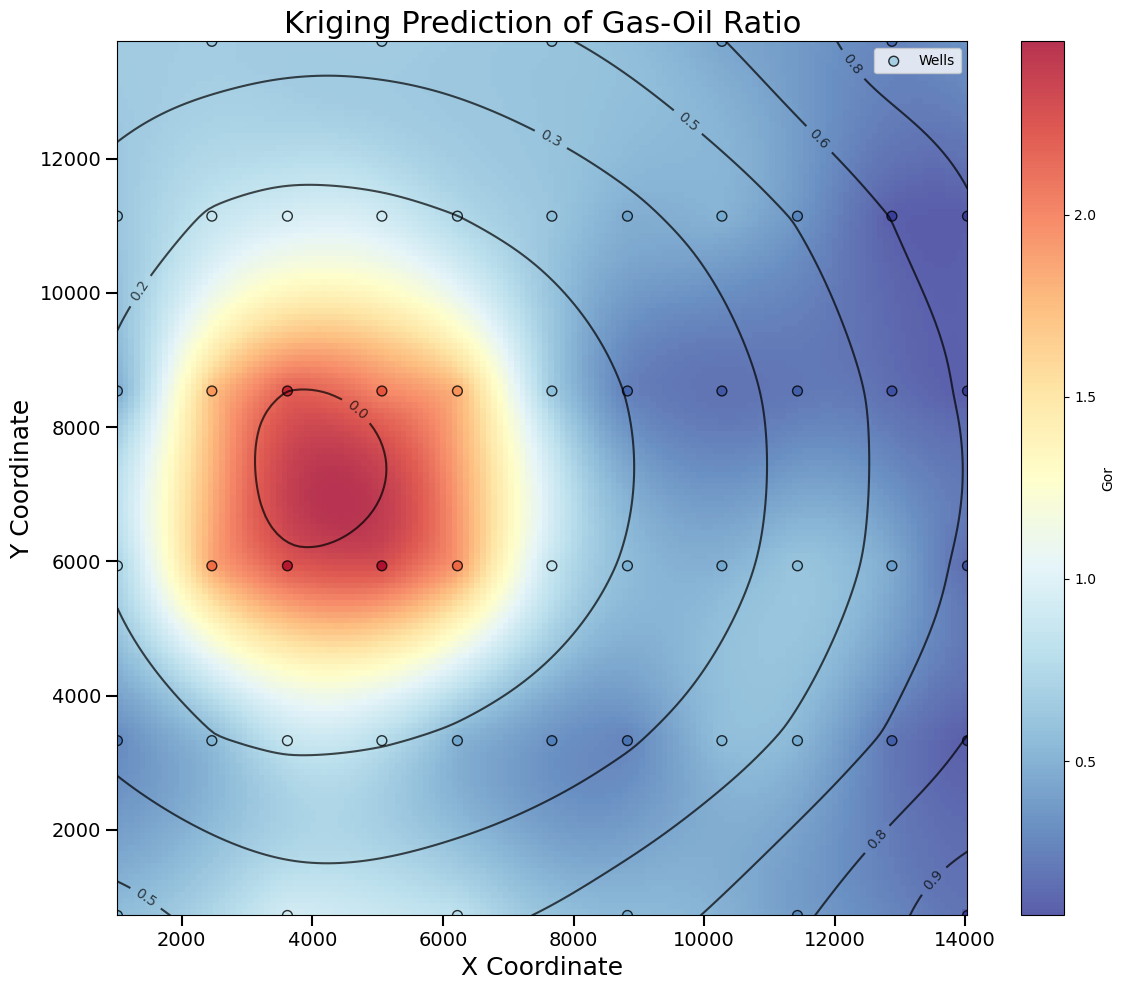

In [536]:
# Classify wells by fluid dominance using GOR
df_scaled['GOR'] = df_scaled['gas_prod_mmcf'] / (df_scaled['oil_prod_mstb'] + 0.001)
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'GOR', 
                    'Kriging Prediction of Gas-Oil Ratio',
                    cmap='RdYlBu_r', add_contours=True, contour_col='total_depth_md')
plt.show()

In [537]:
# Features for facies prediction
feature_cols = ['bh_x', 'bh_y', 'total_depth_md', 'porosity', 'perm_hm', 'past_pressure']

X = df_scaled[feature_cols].copy()
y = df_scaled['facies'].copy()

# Handle any missing values
X = X.fillna(X.median())

# Split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=SEED,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1
)

rf_classifier.fit(X_train, y_train)

# Evaluate
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
train_score = rf_classifier.score(X_train, y_train)
test_score = rf_classifier.score(X_test, y_test)
cv_scores = cross_val_score(rf_classifier, X, y, cv=cv, scoring="accuracy")
print(f"Cross-validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

Cross-validation Accuracy: 0.909 (+/- 0.141)


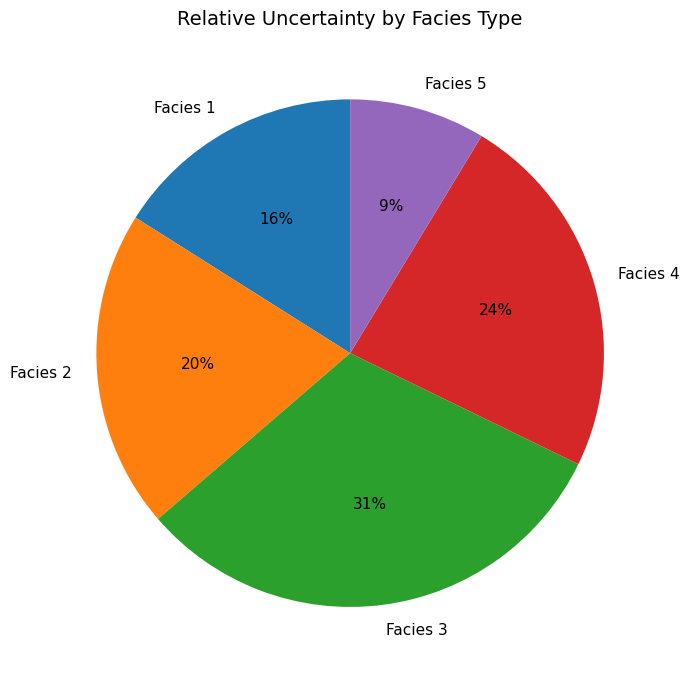

In [538]:
# Get predicted class probabilities
proba = rf_classifier.predict_proba(X)          # shape (n_samples, n_classes)
classes = rf_classifier.classes_                      # array of facies labels

# For each sample, probability assigned to its true facies
true_class_index = np.array([np.where(classes == f)[0][0] for f in y])
true_proba = proba[np.arange(len(y)), true_class_index]

# Define uncertainty as 1 - p(true facies)
sample_uncertainty = 1.0 - true_proba

# Aggregate mean uncertainty per facies
facies_uncertainty = []
for fac in classes:
    mask = (y == fac)
    facies_uncertainty.append(sample_uncertainty[mask].mean())

facies_uncertainty = np.array(facies_uncertainty)

# Normalize to sum to 100% for a pie chart
sizes = facies_uncertainty / facies_uncertainty.sum() * 100
labels = [f'Facies {fac}' for fac in classes]

# Plot pie chart
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.0f%%',
    startangle=90,
    textprops={'fontsize': 11}
)
ax.set_title('Relative Uncertainty by Facies Type', fontsize=14)
ax.axis('equal')
plt.tight_layout()
plt.show()

In [539]:
# Check for common samples in train/test
common_indices = set(X_train.index).intersection(set(X_test.index))
print("Common samples in train/test:", common_indices)

Common samples in train/test: set()


In [540]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance for Facies Prediction:")
print(feature_importance)


Feature Importance for Facies Prediction:
          feature  importance
3        porosity    0.389469
4         perm_hm    0.299632
5   past_pressure    0.096542
2  total_depth_md    0.093853
0            bh_x    0.062201
1            bh_y    0.058302


In [541]:
# Create dense grid over field
x_min, x_max = df['bh_x'].min(), df['bh_x'].max()
y_min, y_max = df['bh_y'].min(), df['bh_y'].max()

grid_x = np.linspace(x_min, x_max, 100)
grid_y = np.linspace(y_min, y_max, 100)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

In [542]:
# Krige all features
grid_depth = krige_to_grid(df_scaled, 'total_depth_md', grid_x, grid_y)
grid_porosity = krige_to_grid(df_scaled, 'porosity', grid_x, grid_y)
grid_perm = krige_to_grid(df_scaled, 'perm_hm', grid_x, grid_y)
grid_pressure = krige_to_grid(df_scaled, 'past_pressure', grid_x, grid_y)

In [543]:
# Prepare grid features for prediction
grid_features = np.column_stack([
    grid_xx.ravel(),
    grid_yy.ravel(),
    grid_depth.ravel(),
    grid_porosity.ravel(),
    grid_perm.ravel(),
    grid_pressure.ravel()
])

# Predict facies class
facies_pred = rf_classifier.predict(grid_features)
facies_pred_grid = facies_pred.reshape(grid_xx.shape)

# Predict probabilities for each facies
facies_proba = rf_classifier.predict_proba(grid_features)

c:\Users\shake\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\shake\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


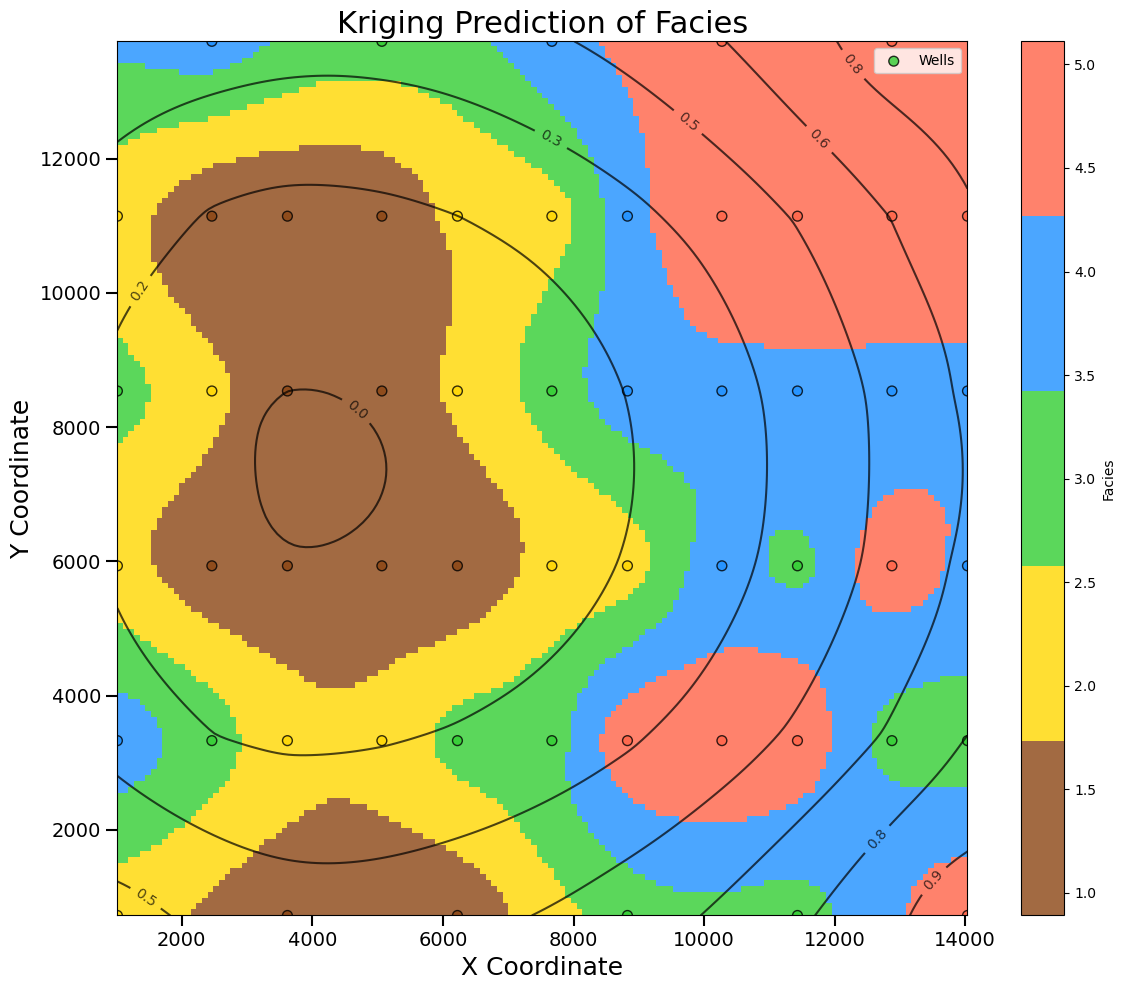

In [544]:
# Create custom colormap for facies
facies_colors = ['#8B4513', '#FFD700', '#32CD32', '#1E90FF', '#FF6347']
facies_cmap = ListedColormap(facies_colors[:len(np.unique(y))])

create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'facies', 
                    'Kriging Prediction of Facies',
                    cmap=facies_cmap, add_contours=True, contour_col='total_depth_md')
plt.show()

In [545]:
# Compute average production by facies
facies_production = df_scaled.groupby('facies').agg({
    'oil_prod_mstb': ['mean', 'median', 'std'],
    'gas_prod_mmcf': ['mean', 'median', 'std']
}).round(3)

print("Production Statistics by Facies:")
print(facies_production)

Production Statistics by Facies:
       oil_prod_mstb               gas_prod_mmcf              
                mean median    std          mean median    std
facies                                                        
1              0.576  0.413  0.261         0.816  0.860  0.142
2              0.756  0.869  0.243         0.591  0.593  0.109
3              0.469  0.347  0.352         0.188  0.170  0.130
4              0.470  0.400  0.330         0.139  0.130  0.118
5              0.096  0.008  0.192         0.025  0.006  0.033


In [546]:
# Create facies quality score based on historical production
facies_quality = df_scaled.groupby('facies').agg({
    'oil_prod_mstb': 'mean',
    'gas_prod_mmcf': 'mean',
    'porosity': 'mean',
    'perm_hm': 'mean'
})
# Normalize facies scores
facies_quality['quality_score'] = (
    (facies_quality['oil_prod_mstb'] / facies_quality['oil_prod_mstb'].max()) * 0.35 +
    (facies_quality['gas_prod_mmcf'] / facies_quality['gas_prod_mmcf'].max()) * 0.35 +
    (facies_quality['porosity'] / facies_quality['porosity'].max()) * 0.15 +
    (facies_quality['perm_hm'] / facies_quality['perm_hm'].max()) * 0.15
)

print("\nFacies Quality Scores:")
print(facies_quality['quality_score'].sort_values(ascending=False))


Facies Quality Scores:
facies
1    0.916848
2    0.843851
3    0.460190
4    0.378507
5    0.079254
Name: quality_score, dtype: float64


In [547]:
# Map facies quality back to dataframe
df_scaled['facies_quality'] = df_scaled['facies'].map(facies_quality['quality_score'])

In [548]:
# Train Random Forest Classifier for facies prediction
feature_cols = ['total_depth_md', 'porosity', 'perm_hm', 'past_pressure']
X_facies = df_scaled[feature_cols].fillna(df_scaled[feature_cols].median())
y_facies = df_scaled['facies']

rf_facies = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=SEED,
    class_weight='balanced',
    n_jobs=-1
)

rf_facies.fit(X_facies, y_facies)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_split=5, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [549]:
# Define composite production target
df_scaled['target_production'] = df_scaled['oil_prod_mstb'] + (df_scaled['gas_prod_mmcf'])

# Features including facies information
production_features = ['total_depth_md', 'porosity', 
                       'perm_hm', 'past_pressure']

X_prod = df_scaled[production_features].fillna(df_scaled[production_features].median())
y_prod = df_scaled['target_production']

In [550]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=SEED,
    subsample=1,
    colsample_bytree=1,
    tree_method="exact",
)

xgb_model.fit(X_prod, y_prod)

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
print(f"\nProduction Model CV R²: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")


Production Model CV R²: 0.909 (+/- 0.141)


In [551]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': production_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance for Production:")
print(feature_importance)


Feature Importance for Production:
          feature  importance
0  total_depth_md    0.538059
1        porosity    0.259209
2         perm_hm    0.202732
3   past_pressure    0.000000


In [552]:
# Create spatial grid
x_min, x_max = df['bh_x'].min(), df['bh_x'].max()
y_min, y_max = df['bh_y'].min(), df['bh_y'].max()

grid_x = np.linspace(x_min, x_max, 150)
grid_y = np.linspace(y_min, y_max, 150)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

print("\nKriging features to grid...")
grid_depth = krige_to_grid(df_scaled, 'total_depth_md', grid_x, grid_y)
grid_porosity = krige_to_grid(df_scaled, 'porosity', grid_x, grid_y)
grid_perm = krige_to_grid(df_scaled, 'perm_hm', grid_x, grid_y)
grid_pressure = krige_to_grid(df_scaled, 'past_pressure', grid_x, grid_y)


Kriging features to grid...


In [553]:
# Predict facies on grid
grid_features_facies = np.column_stack([
    grid_depth.ravel(),
    grid_porosity.ravel(),
    grid_perm.ravel(),
    grid_pressure.ravel()
])

predicted_facies = rf_facies.predict(grid_features_facies)
predicted_facies_grid = predicted_facies.reshape(grid_xx.shape)

c:\Users\shake\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [554]:
# Map facies to quality scores
facies_quality_grid = np.vectorize(facies_quality['quality_score'].to_dict().get)(predicted_facies_grid)

In [555]:
# Predict production on grid using facies quality
grid_features_production = np.column_stack([
    grid_depth.ravel(),
    grid_porosity.ravel(),
    grid_perm.ravel(),
    grid_pressure.ravel(),
])

predicted_production = xgb_model.predict(grid_features_production)
predicted_production_grid = predicted_production.reshape(grid_xx.shape)

In [556]:
# Normalize to sweet spot score (0-1)
sweet_spot_score = (predicted_production_grid - predicted_production_grid.min()) / \
                   (predicted_production_grid.max() - predicted_production_grid.min())

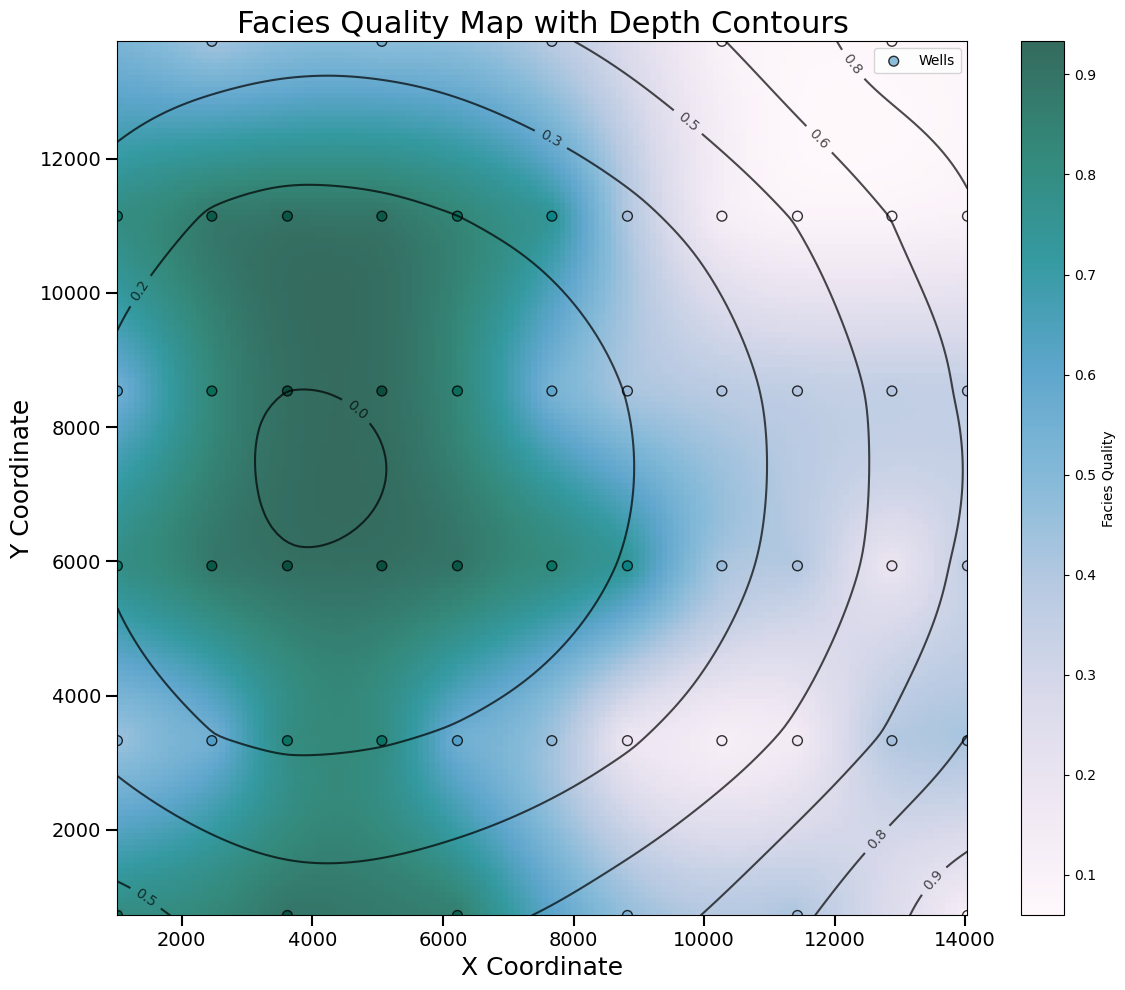

In [557]:
#Add facies quality to dataframe for plotting
df_scaled['facies_quality'] = df_scaled['facies'].map(facies_quality['quality_score'])
# Plot facies quality map with contours
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'facies_quality',
                    'Facies Quality Map with Depth Contours',
                    cmap='PuBuGn', add_contours=True, contour_col='total_depth_md')
plt.show()

In [558]:
# # Add predicted production to dataframe for plotting
df_scaled['target_production'] = df_scaled['oil_prod_mstb'] + df_scaled['gas_prod_mmcf']

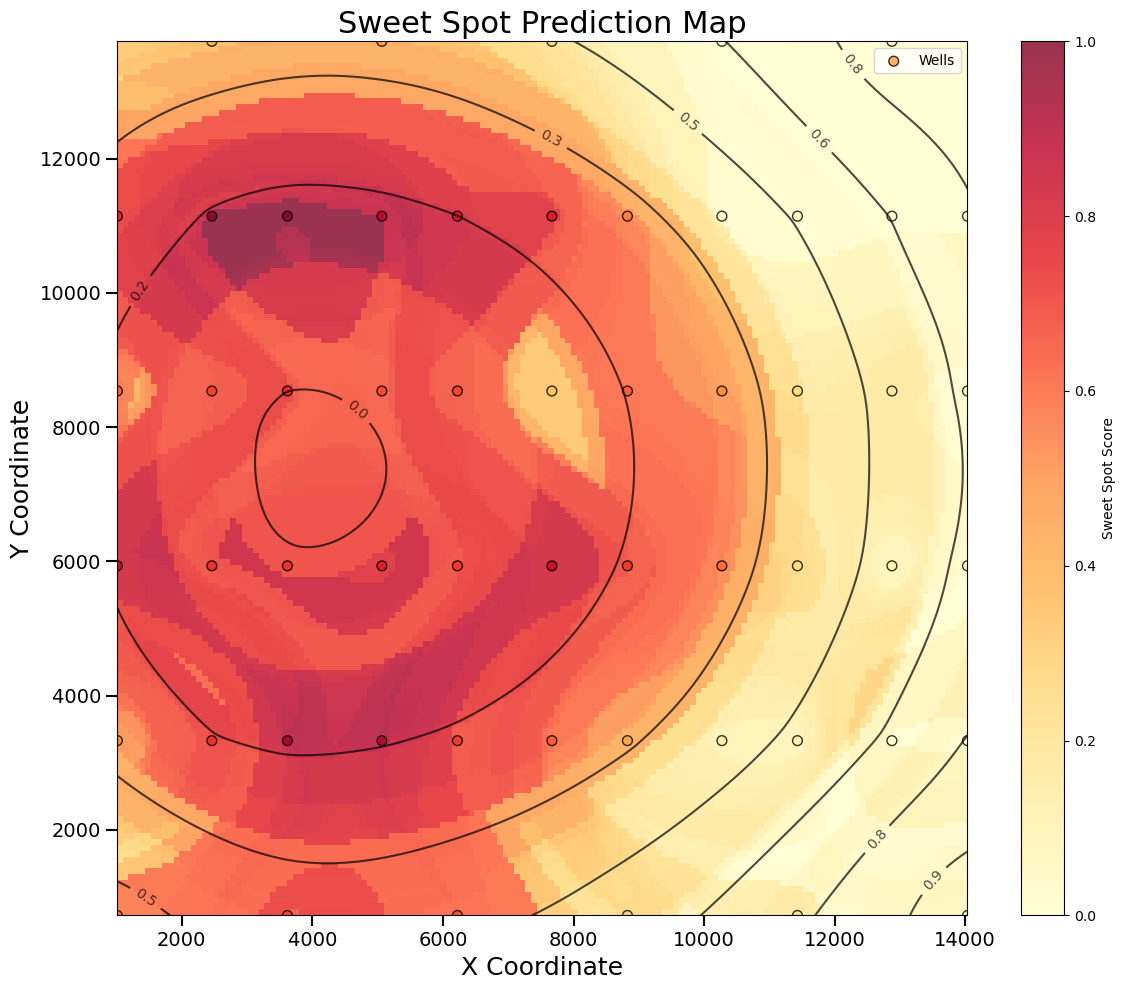

In [559]:
# Prepare grids
grid_x = np.linspace(df_scaled['bh_x'].min(), df_scaled['bh_x'].max(), 150)
grid_y = np.linspace(df_scaled['bh_y'].min(), df_scaled['bh_y'].max(), 150)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

# Prepare kriged grids
depth_grid = krige_to_grid(df_scaled, 'total_depth_md', grid_x, grid_y)   
sweet_spot_score_grid = sweet_spot_score.reshape(grid_xx.shape)          

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(
    sweet_spot_score_grid,                                               
    extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
    origin='lower',
    cmap='YlOrRd',
    aspect='auto',
    alpha=0.8
)
plt.colorbar(im, ax=ax, label='Sweet Spot Score')

# Get grid indices for wells
x_idx = np.searchsorted(grid_x, df_scaled['bh_x'])
y_idx = np.searchsorted(grid_y, df_scaled['bh_y'])
x_idx = np.clip(x_idx, 0, len(grid_x) - 1)
y_idx = np.clip(y_idx, 0, len(grid_y) - 1)

# Color wells by sweet spot scores (note: [y_idx, x_idx])
well_scores = sweet_spot_score_grid[y_idx, x_idx]

ax.scatter(
    df_scaled['bh_x'], df_scaled['bh_y'],
    c=well_scores,
    cmap='YlOrRd',
    s=50, edgecolor='black', linewidth=1, alpha=0.8, label='Wells'
)

# Add depth contours (same grid_x, grid_y, orientation as heatmap)
OK_depth = OrdinaryKriging(
    df_scaled['bh_x'], df_scaled['bh_y'], df_scaled['total_depth_md'],
    variogram_model='spherical', verbose=False, enable_plotting=False
)
depth_pred, _ = OK_depth.execute('grid', grid_x, grid_y)  # shape (ny, nx)

contours = ax.contour(
    grid_x, grid_y, depth_pred,
    colors='black', linewidths=1.5, levels=8, alpha=0.7
)
ax.clabel(contours, inline=True, fontsize=10, fmt='%0.1f')

# Formatting
ax.set_xlabel('X Coordinate', fontsize=18)
ax.set_ylabel('Y Coordinate', fontsize=18)
ax.set_title('Sweet Spot Prediction Map', fontsize=22)
ax.legend()
ax.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
plt.tight_layout()
plt.show()

In [560]:
# Detect peaks
coordinates = peak_local_max(
    sweet_spot_score_grid,
    min_distance=5,      
    threshold_abs=0.4     
)

cand_x = grid_x[coordinates[:, 1]]
cand_y = grid_y[coordinates[:, 0]]
cand_scores = sweet_spot_score[coordinates[:, 0], coordinates[:, 1]]

In [561]:
# Existing wells
well_x = df_scaled['bh_x'].values
well_y = df_scaled['bh_y'].values

min_well_dist = 1100      
min_spot_dist = 1200   
score_threshold = 0.6

selected_idx = []

for i in np.argsort(cand_scores)[::-1]:     
    sx, sy, sscore = cand_x[i], cand_y[i], cand_scores[i]
    if sscore < score_threshold:
        continue

    # distance to existing wells
    d_wells = np.sqrt((sx - well_x)**2 + (sy - well_y)**2)
    if d_wells.min() < min_well_dist:
        continue

    # distance to already selected new spots
    if selected_idx:
        d_new = np.sqrt((sx - cand_x[selected_idx])**2 +
                        (sy - cand_y[selected_idx])**2)
        if d_new.min() < min_spot_dist:
            continue

    selected_idx.append(i)

bonus_x = cand_x[selected_idx]
bonus_y = cand_y[selected_idx]
bonus_scores = cand_scores[selected_idx]

print("New locations selected:", len(bonus_x))
for i, (x, y, s) in enumerate(zip(bonus_x, bonus_y, bonus_scores), 1):
    print(f"Spot {i}: ({x:.0f}, {y:.0f}) score={s:.3f}")

New locations selected: 6
Spot 1: (5645, 10076) score=0.882
Spot 2: (4421, 2385) score=0.835
Spot 3: (4246, 9551) score=0.824
Spot 4: (1799, 4220) score=0.763
Spot 5: (6693, 12261) score=0.690
Spot 6: (4334, 12872) score=0.686


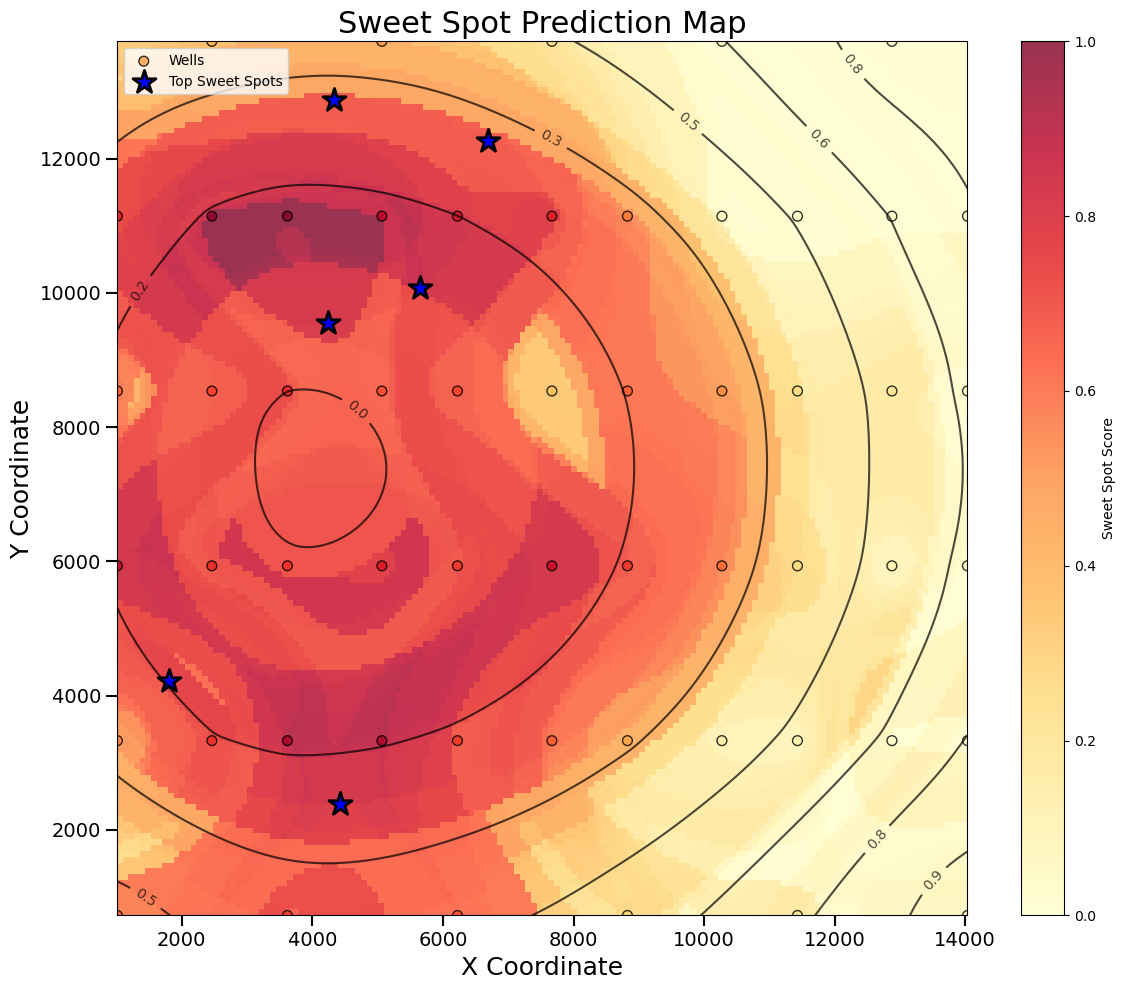

In [562]:
# Prepare grids
grid_x = np.linspace(df_scaled['bh_x'].min(), df_scaled['bh_x'].max(), 150)
grid_y = np.linspace(df_scaled['bh_y'].min(), df_scaled['bh_y'].max(), 150)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

# Prepare kriged grids
depth_grid = krige_to_grid(df_scaled, 'total_depth_md', grid_x, grid_y)   
sweet_spot_score_grid = sweet_spot_score.reshape(grid_xx.shape)          

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(
    sweet_spot_score_grid,
    extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
    origin='lower',
    cmap='YlOrRd',
    aspect='auto',
    alpha=0.8
)
plt.colorbar(im, ax=ax, label='Sweet Spot Score')

# Get grid indices for wells
x_idx = np.searchsorted(grid_x, df_scaled['bh_x'])
y_idx = np.searchsorted(grid_y, df_scaled['bh_y'])
x_idx = np.clip(x_idx, 0, len(grid_x) - 1)
y_idx = np.clip(y_idx, 0, len(grid_y) - 1)

# Color wells by sweet spot scores 
well_scores = sweet_spot_score_grid[y_idx, x_idx]

ax.scatter(
    df_scaled['bh_x'], df_scaled['bh_y'],
    c=well_scores,
    cmap='YlOrRd',
    s=50, edgecolor='black', linewidth=1, alpha=0.8, label='Wells'
)

ax.scatter(
    bonus_x, bonus_y,
    c='blue', s=300, marker='*', edgecolor='black', linewidth=2, label='Top Sweet Spots'
)

# Add contours (same orientation as heatmap)
contours = ax.contour(
    grid_x, grid_y, depth_grid,   
    colors='black', linewidths=1.5, levels=8, alpha=0.7
)
ax.clabel(contours, inline=True, fontsize=10, fmt='%0.1f')

# Formatting
ax.set_xlabel('X Coordinate', fontsize=18)
ax.set_ylabel('Y Coordinate', fontsize=18)
ax.set_title('Sweet Spot Prediction Map', fontsize=22)
ax.legend()
ax.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
plt.tight_layout()
plt.show()